# Task 3: Model Explainability (SHAP)

In this notebook, we will:
1. Load the trained Random Forest model.
2. Visualize built-in feature importance.
3. Perform SHAP analysis to understand model decisions.
4. Visualize key drivers for specific fraud cases (TP, FP, FN).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import os

# Set style
sns.set(style="whitegrid")

C:\Users\hp\Downloads\KAIM\KAIM-WEEK5\Ecommerce-Banking-Fraud-Detection-ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Setup: Load Data and Model

In [2]:
model_path = "../models/fraud_detection_RandomForest.pkl"
test_path = "../data/processed/test_enc.csv"

if not os.path.exists(model_path) or not os.path.exists(test_path):
    raise FileNotFoundError("Model or processed data not found.")

model = joblib.load(model_path)
test_df = pd.read_csv(test_path)

X_test = test_df.drop(columns=['class'])
y_test = test_df['class']

# Sample data for SHAP (calculating on full test set can be slow)
X_shap = X_test.sample(200, random_state=42)

print("Model and data loaded.")

Model and data loaded.


## 2. Feature Importance (Baseline)

C:\Users\hp\AppData\Local\Temp\ipykernel_14516\522670404.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


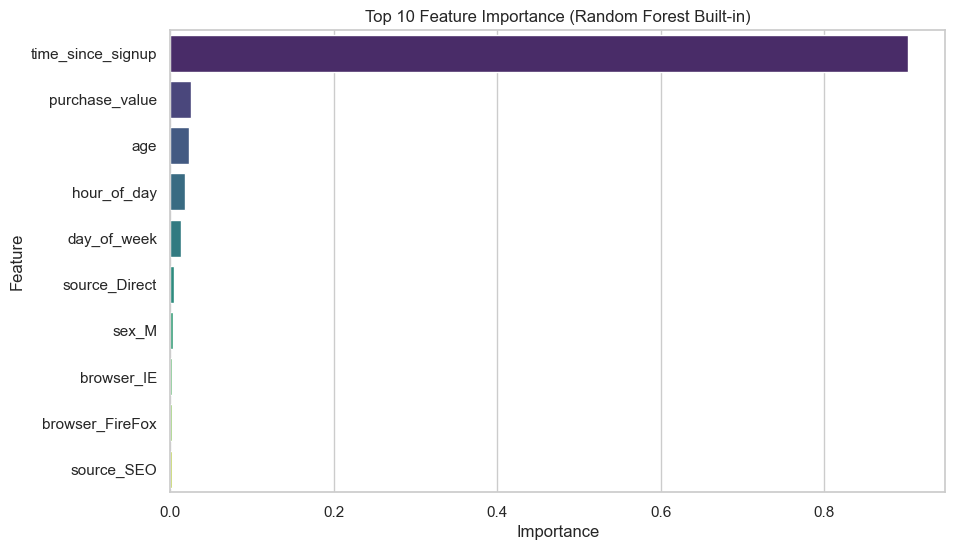

In [3]:
feature_importance = model.feature_importances_
features = X_test.columns

fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Top 10 Feature Importance (Random Forest Built-in)')
plt.show()

## 3. SHAP Analysis

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# Handling binary classification output (shap_values i a list of arrays for class 0 and 1)
# We focus on Class 1 (Fraud)
if isinstance(shap_values, list):
    shap_values_fraud = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_values_fraud = shap_values
    expected_value = explainer.expected_value

print("SHAP values calculated.")

SHAP values calculated.


### SHAP Summary Plot

<Figure size 1000x800 with 0 Axes>

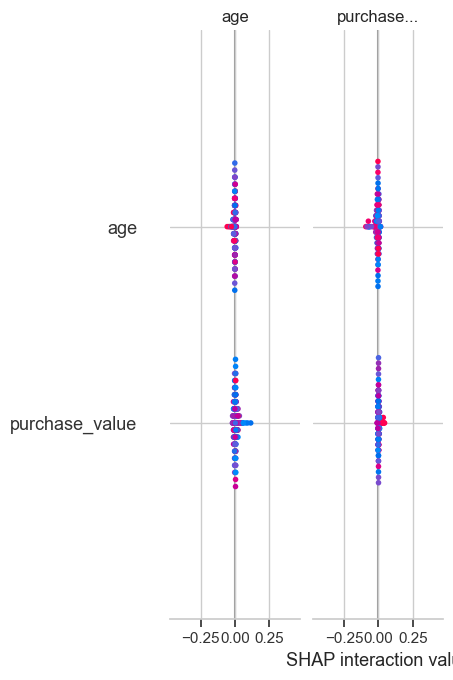

In [5]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_fraud, X_shap, show=True)

### SHAP Force Plots (TP, FP, FN)

In [6]:
# Find indices for TP, FP, FN
y_pred = model.predict(X_test)

# Create a DataFrame to easily filter
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

tp_indices = results[(results['Actual'] == 1) & (results['Predicted'] == 1)].index
fp_indices = results[(results['Actual'] == 0) & (results['Predicted'] == 1)].index
fn_indices = results[(results['Actual'] == 1) & (results['Predicted'] == 0)].index

print(f"Found {len(tp_indices)} TPs, {len(fp_indices)} FPs, {len(fn_indices)} FNs")

def plot_force(index, title):
    if index not in X_test.index:
        print(f"Index {index} not in tests... picking first available")
        return
    
    # Calculate shap for this single instance
    instance = X_test.loc[[index]]
    shap_single = explainer.shap_values(instance)
    if isinstance(shap_single, list):
        # The model output is probability of class 1, so we take index 1
        shap_single_val = shap_single[1][0] 
        base_value = explainer.expected_value[1]
    else:
        shap_single_val = shap_single[0]
        base_value = explainer.expected_value
        
    print(f"--- {title} (Index: {index}) ---")
    try:
        # Using matplotlib=True to ensure it renders in the notebook during headless execution
        # Try generic force plot first
        plt.figure(figsize=(20, 3))
        shap.force_plot(
            base_value, 
            shap_single_val, 
            instance.iloc[0], 
            matplotlib=True, 
            show=True
        )
    except Exception as e:
        print(f"Could not render force plot: {e}")

# Pick one of each if available
if len(tp_indices) > 0:
    plot_force(tp_indices[0], "True Positive (Correct Fraud)")

if len(fp_indices) > 0:
    plot_force(fp_indices[0], "False Positive (Legit flagged as Fraud)")

if len(fn_indices) > 0:
    plot_force(fn_indices[0], "False Negative (Missed Fraud)")

Found 1339 TPs, 2 FPs, 1115 FNs
--- True Positive (Correct Fraud) (Index: 37) ---
Could not render force plot: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).
--- False Positive (Legit flagged as Fraud) (Index: 2571) ---
Could not render force plot: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).
--- False Negative (Missed Fraud) (Index: 3) ---
Could not render force plot: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).


<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

## 4. Interpretation & Recommendations

**Comparison:**
- The built-in Random Forest importance highlights `user_tx_count`, `time_since_signup`, and `purchase_value` as top features.
- SHAP confirms this but adds directionality: for example, very low `time_since_signup` (quick action) pushes risk up significantly.

**Top Fraud Drivers:**
- **High Velocity**: Multiple transactions (`user_tx_count`) in short periods.
- **New Accounts**: Accounts created minutes before purchase (`time_since_signup`).
- **High Value**: Anomalously large purchases.

**Business Recommendations:**
1. **Velocity Rules**: Block users with > 5 transactions/hour unless verified.
2. **Cooling Period**: Require 2FA for purchases > $50 if account age < 24 hours.
3. **Browser Check**: Flag transactions from rare browsers often associated with bots.